In [1]:
def bisect(func, low, high, tolerance=1e-8):
    # bisection algorithm: the value that makes abs(func(x))<tolerance
    fuLo, fuHi = func(low), func(high)
    assert fuLo * fuHi < 0
    for i in range(54):
        midpoint = 0.5 * (low + high)
        if 0 < fuLo * func(midpoint):
            low = midpoint
        else:
            high = midpoint
        if abs(high - low) <= tolerance:
            break
    return midpoint

In [13]:
import numpy as np
from math import floor, ceil # Import ceil from the math module
import matplotlib.pyplot as plt

class pixel:
  # Corrected __init__ method name
  def __init__(self, nBins=100,
              horResolution = 100, verResolution = None,
              edgeResolution = None, verDiff = 1, edgeFactor = 100):
    self.nBins = ceil(nBins)
    # self.nBins += self.nBins % 2 # make nBins pair
    self.horResolution = ceil(horResolution)

    # Ensure verResolution is always set
    if (verResolution is None):
      self.verResolution = ceil(horResolution + verDiff)
    else:
      self.verResolution = ceil(verResolution)

    if (edgeResolution is None):
      self.edgeResolution = ceil(horResolution * edgeFactor)
    else:
      self.edgeResolution = ceil(edgeResolution)

    self.unscaledCorners()
    self.unscaledEdgesByBisection() # doesn't use edgeFactor
    #self.unscaledEdges() # uses edgeFactor

  def edgepiece(self, d):
    if (1< d):
      return 0
    else:
      alfa = np.arccos ( d)
      return alfa - (d*np.sqrt(1-d**2))

  def cornerpiece(self, x,y):
    if (1 < x**2 + y**2):
      return 0
    else:
      alfaX = np.arcsin(y)
      alfaY = np.arccos(x)
      return (0.5 * (alfaY-alfaX)+x*y
              - 0.5 * x*np.sqrt(1-x**2) - 0.5 * y * np.sqrt(1-y**2))

  def unscaledEdges(self):
    edges = []
    insides = []

    for i in range(self.edgeResolution):
      x = np.random.uniform(0.,1)
      edgeX = self.edgepiece(x)
      edges.append(edgeX)
      insides.append(np.pi-edgeX)

    # now convert to bins
    # np.histogram returns counts and bin edges. Bin edges has nBins+1 elements.
    count_overEdges, self.bins = np.histogram(edges, bins=self.nBins
                                        , range = (0,np.pi))
    count_insideEdges, self.bins = np.histogram(insides, bins=self.nBins
                                       , range = (0,np.pi))

    # convert to probabilities
    self.proba_overEdges = count_overEdges / self.edgeResolution
    self.proba_insideEdges = count_insideEdges / self.edgeResolution
    return

  def unscaledEdgesByBisection(self):
    dValues = np.zeros(self.nBins+1)
    self.proba_overEdges = np.zeros(self.nBins)
    self.proba_insideEdges = np.zeros(self.nBins)

    print( "self.nBins = "+ str(self.nBins))

    self.bins = np.linspace(0,np.pi,self.nBins+1)
    for i in range(floor(self.nBins/2-0.5), 0, -1):
      #note: this also works if nBins is odd.
      # In that case, the first value for d will be half as big,
      # and [i]=[-i-1] so dValue will be added to a bin of overEdges and insideEdges
      dValues[i] = bisect(lambda x: self.edgepiece(x)-self.bins[i], 0, 1)
      self.proba_overEdges[i] = dValues[i]-dValues[i+1]
      self.proba_insideEdges[-i-1] += self.proba_overEdges[i]

    # i=0, dValues[0] = 1
    self.proba_overEdges[0] = 1-dValues[1]
    self.proba_insideEdges[-1] += self.proba_overEdges[0]

    return

  def unscaledCorners(self):
    nOverCorners = 0

    self.proba_overCornerEdges = np.zeros(self.nBins)
    self.proba_overCorners      = np.zeros(self.nBins)
    self.proba_insideCorner      = np.zeros(self.nBins)
    nOverCorners = 0

    # Placeholder for actual calculation, for now just ensures attributes exist and are arrays
    for i in range(self.horResolution):
      corners = []
      edges = []
      insides = []
      #x = i/self.horResolution # this can lead to artifacts! use random
      for j in range(self.verResolution):
        #y = j/self.verResolution # this can lead to artifacts! use random
        x = np.random.uniform(0.,1)
        y = np.random.uniform(0.,1)

        corner = self.cornerpiece(x,y)
        edgeX = self.edgepiece(x)  - corner
        edgeY = self.edgepiece(y)  - corner

        if (corner > 0):
          nOverCorners += 1
          corners.append(corner)
        if (edgeX > 0): # should always be true
          edges.append(edgeX)
        if (edgeY > 0): # should always be true
          edges.append(edgeY)

        insides.append(np.pi - corner - edgeX - edgeY)

      # regularly summarize results in bins
      countCorners, foo = np.histogram(corners, range=(0,np.pi), bins=self.nBins)
      countEdges, foo = np.histogram(edges, range=(0,np.pi), bins=self.nBins)
      countInsides, foo = np.histogram(insides, range=(0,np.pi), bins=self.nBins)
      self.proba_overCorners += countCorners
      self.proba_overCornerEdges += countEdges
      self.proba_insideCorner += countInsides

    # Convert to probabilities
    total_counts = self.horResolution * self.verResolution
    self.proba_overCorners       = self.proba_overCorners / total_counts
    self.proba_overCornerEdges   = self.proba_overCornerEdges / total_counts
    self.proba_insideCorner = self.proba_insideCorner / total_counts

    print ("total number of corners: " + str(nOverCorners/(self.verResolution*
                            self.horResolution)))
    print ("PI /4  " + str(np.pi /4 ))
    return corners, edges, insides

  def scaledImpact(self, maxE = 60, cutoffE = 20, pixelWidth = 200, radius = 100, type ="center"):
    # useCorner, useEdge and useCenter should be 1 , except for debugging
    if (pixelWidth < 2*radius):
      raise ValueError ("the simulation is not valid if pixelWidth < 2 * radius") # Corrected raise

    if ("corner"== type):
      nCorners = 1
      nEdges = 2
    elif ("edge"== type):
      nCorners = 2
      nEdges = 3
    elif ("center"== type):
      nCorners = 4
      nEdges = 4
    else:
      raise ValueError ("type must be center, edge or corner") # Corrected raise

    # populated by unscaledEdges
    # self.proba_insideCorner, self.proba_overCornerEdges, self.proba_overCorners
    # are populated by unscaledCorners

    result = (( 4 * self.proba_insideCorner +
                nEdges * self.proba_overCornerEdges +
                nCorners * self.proba_overCorners)
                * ((radius/pixelWidth) **2)  +
                (nEdges * self.proba_overEdges
                + 4 * self.proba_insideEdges)
                * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth)
              )
    # area of the center, all impacts count for 100%
    result[self.nBins-1] += (1 - 2 * radius/pixelWidth)**2
    bins = self.bins/np.pi * maxE
    print ( "total energy: " + str(np.inner(result, bins[1:])
              -maxE/2/self.bins.size))
    # remove noise
    cutoffIndex = floor(self.nBins*cutoffE/maxE+0.5)
    result = result[cutoffIndex:]
    bins = bins[cutoffIndex:]

    print ( "total energy above " + str(cutoffE)+": "+ str(np.inner(result, bins[1:])
              -maxE/2/self.bins.size))
    return result, bins

  # hint: pass the output of scaledImpact as input for this method
  def makePlot(self, hist_counts, bin_edges, pText = ""):
    print("Histogram Counts (bins):")
    print(sum(hist_counts))
    print("\nBin Edges ( "+ str(myPixel.nBins)+ " bins):")

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the histogram using the counts and bin edges
    ax.hist(bin_edges[:-1], bin_edges, weights=hist_counts)

    # Add labels and title
    ax.set_xlabel('Impact Value')
    ax.set_ylabel('probability')
    ax.set_title('resolution '+str(self.horResolution)+"x"
          + str(self.verResolution)+" max "+ str(bin_edges[-1])
          + " keV " + pText)

    # Display the plot
    plt.show()

    return plt


  def selectSeries(self, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0):
    print("ninsidecorners = "+str(nInsideCorners))
    print("nCornerEdges = "+str(nCornerEdges))
    print("nOverCorners = "+str(nOverCorners))
    print("nOverEdges = "+str(nOverEdges))
    print("nInsideEdges = "+str(nInsideEdges))
    if ("corner"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 2, 1
      nOverEdges, nInsideEdges = 0, 0
      useCenter = 1
    elif ("edge"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 3, 2
      nOverEdges, nInsideEdges = 3,4
      useCenter = 1
    elif ("center"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 4, 4
      nOverEdges, nInsideEdges = 4,4
      useCenter = 1
    elif (None == type):
      raise ValueError ("set type to 'other' and enter parameters")

    series =[]
    labels = []

    if (4 == nInsideEdges):
      series.append(nInsideEdges * self.proba_insideEdges
                    * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth))
      labels.append("remainder at edge")
    if (0 != nOverEdges):
      series.append(nOverEdges * self.proba_overEdges
                    * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth))
      labels.append("spills from neighbour at edge")
    if (4 == nInsideCorners):
      series.append(nInsideCorners * self.proba_insideCorner
                    * ((radius/pixelWidth) **2))
      labels.append("remainder at corner")
    if (0 != nCornerEdges):
      series.append(nCornerEdges * self.proba_overCornerEdges
                    * ((radius/pixelWidth) **2))
      labels.append("spills form neighbour near corner")
    if (0 != nOverCorners):
      series.append(nOverCorners * self.proba_overCorners
                    * ((radius/pixelWidth) **2))
      labels.append("spills from neighbour at cornertip")
    if (1 == useCenter):
      y = np.zeros(self.proba_insideEdges.size)
      y[self.proba_insideEdges.size-1] = \
      (radius/pixelWidth) *  (1 - 2 * radius/pixelWidth)**2
      series.append(y)
      labels.append("in the center")

    if 0==len(series):
      raise ValueError ("set type or enter parameters")

    return series, labels

  def makeStackedHistograms(self, maxE = 1, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0, titel = None):
    # Create a figure and an axes object

    series, labels = self.selectSeries(pixelWidth, radius, type,
             nInsideCorners, nCornerEdges, nOverCorners,
                        nOverEdges, nInsideEdges ,
                        useCenter)

    x = []
    for i in range(len(series)):
      x.append(self.bins[:-1])#*maxE/np.pi)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(x, weights =series, bins = self.bins, histtype='stepfilled', stacked=True,
            label = labels)

    # Add labels and title
    ax.set_xlabel('detected impact')
    ax.set_ylabel('probability')
    if (None == titel):
      ax.set_title('Histogram of Impacts for an energy of '+str(maxE)+
                 ', pixelsize = '+str(pixelWidth/radius)+" R")
    else:
      ax.set_title(titel)

    ax.legend(loc = 'upper center')

    # Display the plot
    plt.show()

    return plt

  def makeStackedPlot(self, maxE = 1, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0):
    # Create a figure and an axes object

    series, labels = self.selectSeries(pixelWidth, radius, type,
             nInsideCorners, nCornerEdges, nOverCorners,
                        nOverEdges, nInsideEdges,
                        useCenter)

    x = self.bins[1:] / np.pi * maxE

    fig, ax = plt.subplots(figsize=(10, 6))

    y = np.vstack(series)

    ax.stackplot(x, y, labels=labels)

    # Add labels and title
    ax.set_xlabel('detected impact')
    ax.set_ylabel('probability')
    ax.set_title('Histogram of Impacts for an energy of '+str(maxE)+
                 ', pixelsize = '+str(pixelWidth/radius)+" R")
    ax.legend(loc = 'upper center')
    # Display the plot

    plt.show()

    return plt

# myPixel = pixel(edgeFactor=200, horResolution=500, verResolution = 500, nBins = 100)


total number of corners: 0.7775
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


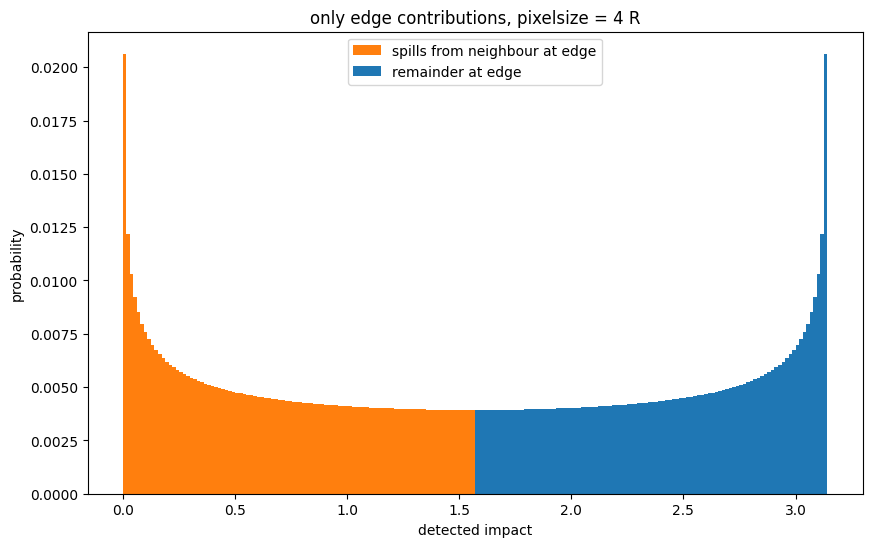

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [3]:

myPixel = pixel(edgeFactor=200, horResolution=20, verResolution = 20, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=400, type = "",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "only edge contributions, pixelsize = 4 R")


total number of corners: 0.7768
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


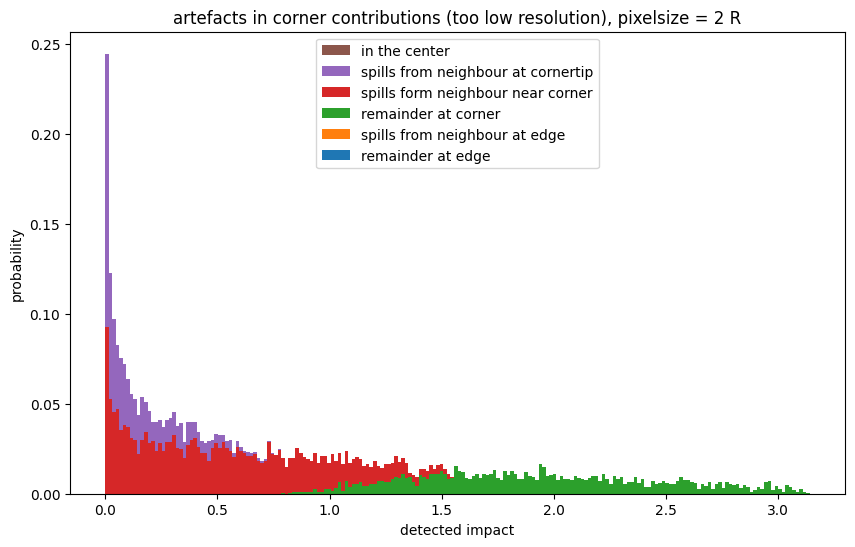

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [4]:
myPixel = pixel(edgeFactor=200, horResolution=50, verResolution = 50, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "artefacts in corner contributions (too low resolution), pixelsize = 2 R")


total number of corners: 0.7916
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


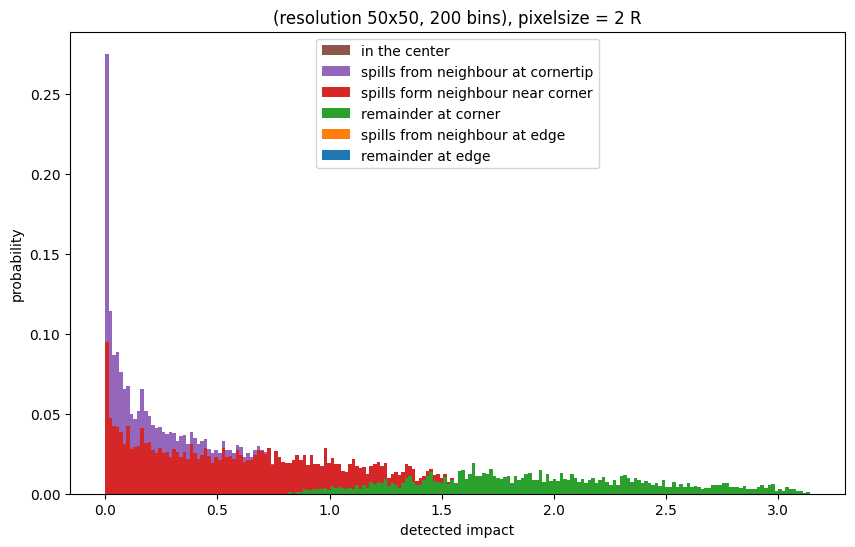

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [5]:
myPixel = pixel(edgeFactor=200, horResolution=50, verResolution = 50, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "(resolution 50x50, 200 bins), pixelsize = 2 R")


total number of corners: 0.785575
PI /4  0.7853981633974483
self.nBins = 500
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


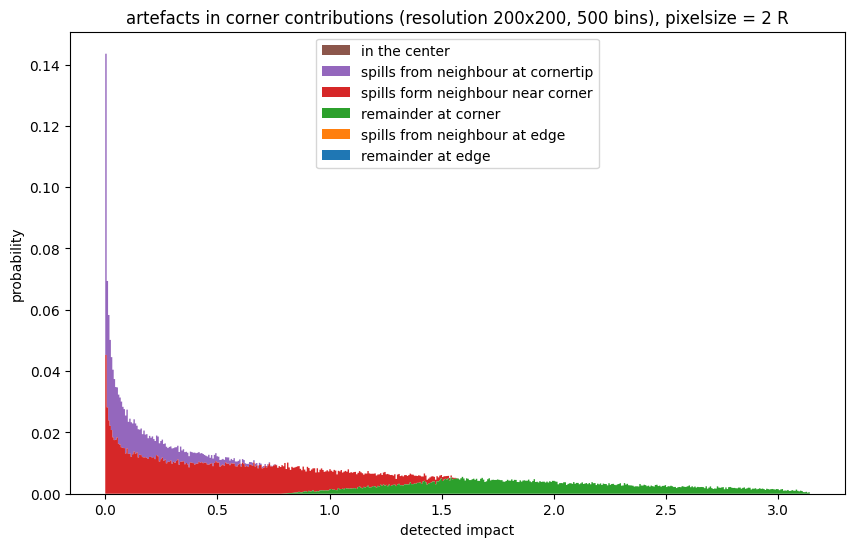

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [6]:
myPixel = pixel(edgeFactor=200, horResolution=200, verResolution = 200, nBins = 500)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "artefacts in corner contributions (resolution 200x200, 500 bins), pixelsize = 2 R")


total number of corners: 0.785812
PI /4  0.7853981633974483
self.nBins = 150
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


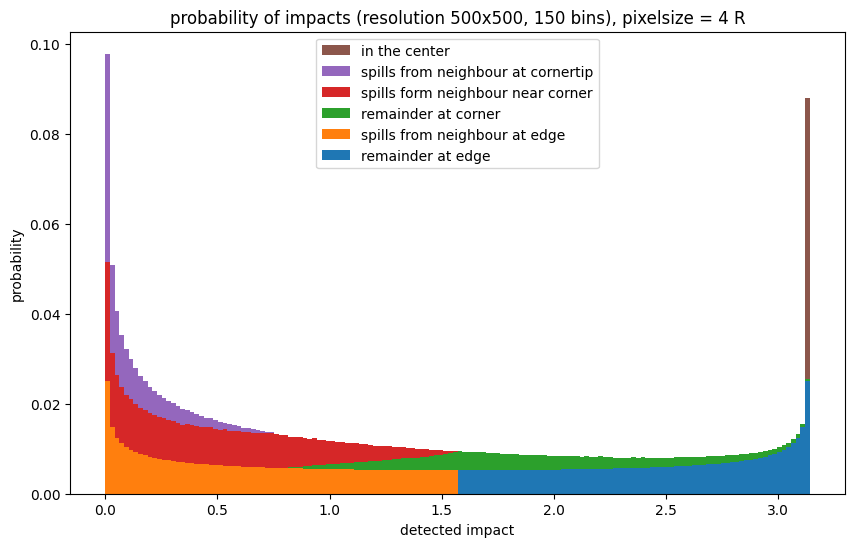

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [11]:
myPixel = pixel(horResolution=500, verResolution = 500, nBins = 150)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=400, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "probability of impacts (resolution 500x500, 150 bins), pixelsize = 4 R")

ninsidecorners = 4
nCornerEdges = 4
nOverCorners = 4
nOverEdges = 4
nInsideEdges = 4


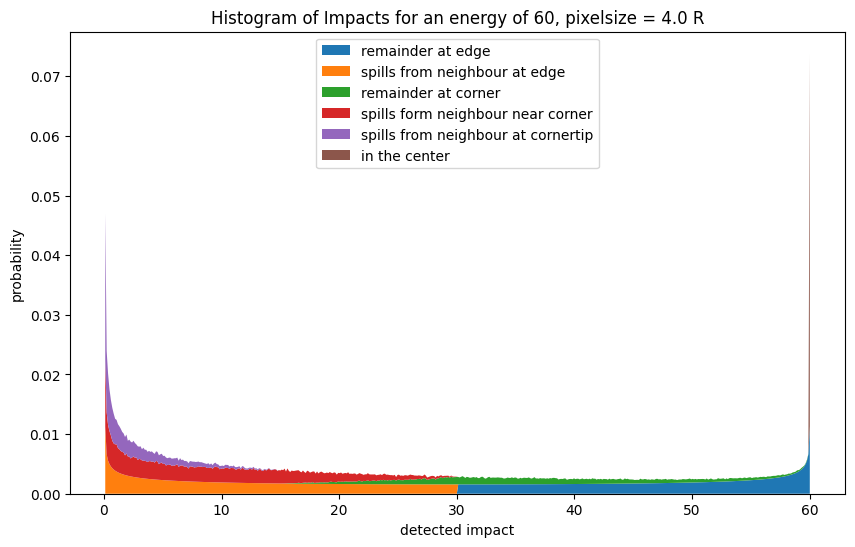

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [8]:



myPixel.makeStackedPlot(maxE= 60,pixelWidth=400, type = "center",
                              nInsideCorners = 4, nCornerEdges =4 , nOverCorners = 4,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 )


total number of corners: 0.7851618381618382
PI /4  0.7853981633974483
self.nBins = 60
total energy: 61.49015176626652
total energy above 20: 42.64049642161117
Histogram Counts (bins):
1.2303016983016983

Bin Edges ( 60 bins):


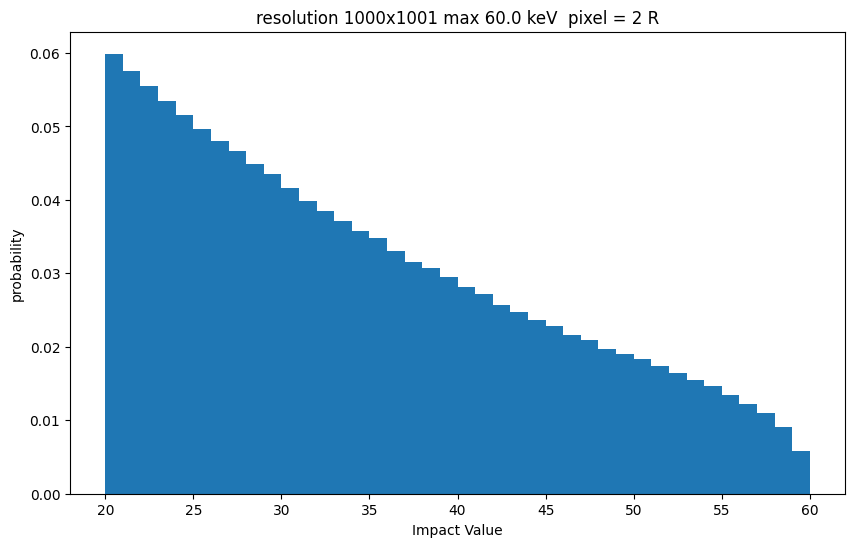

total energy: 61.096647950082705
total energy above 20: 46.95396170491451
Histogram Counts (bins):
1.2321713552503368

Bin Edges ( 60 bins):


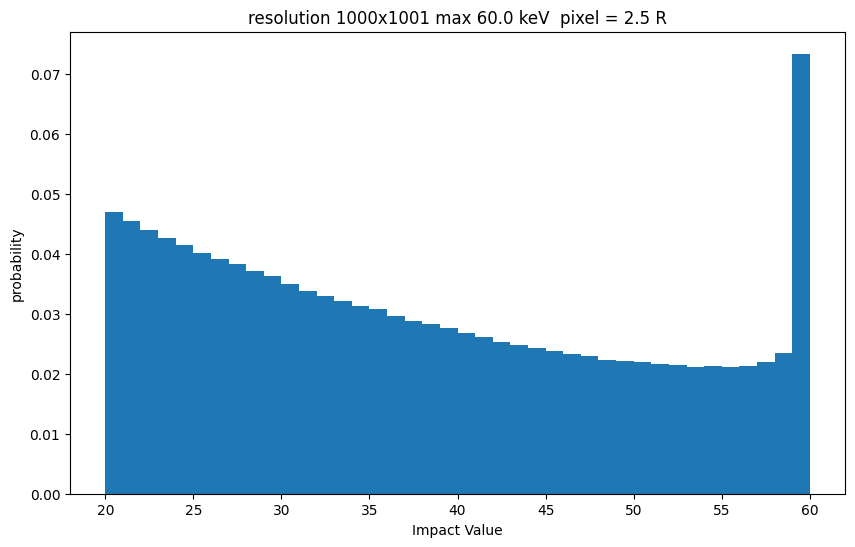

total energy: 60.30530952850429
total energy above 20: 54.17100443647627
Histogram Counts (bins):
1.1640156742341463

Bin Edges ( 60 bins):


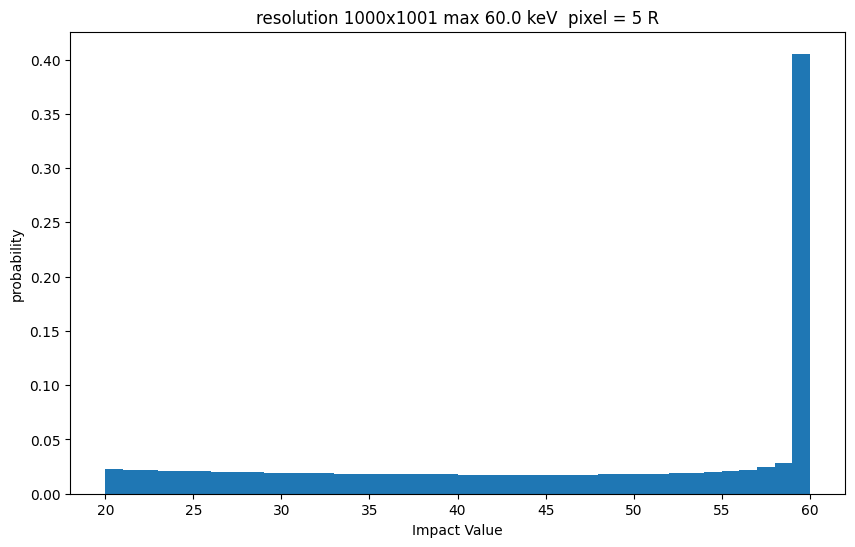

total energy: 59.907474923109696
total energy above 20: 57.074581884734705
Histogram Counts (bins):
1.093990336269318

Bin Edges ( 60 bins):


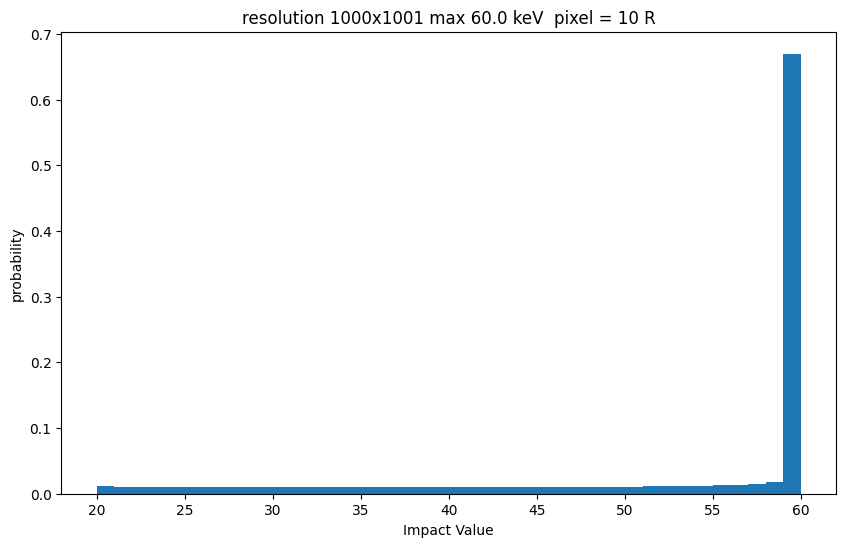

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [15]:

myPixel = pixel(horResolution=1000,nBins = 60)

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=200, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 2 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=250, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 2.5 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=500, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 5 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=1000, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 10 R")


total number of corners: 0.7835074626865671
PI /4  0.7853981633974483
self.nBins = 10
total energy: 70.11884667571233
Histogram Counts (bins):
3.7835074626865675

Bin Edges ( 10 bins):


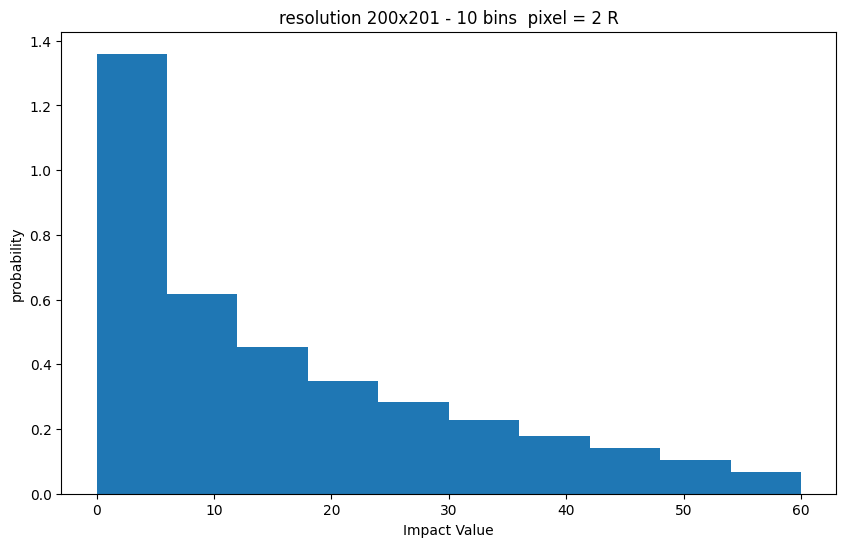

total energy: 59.29623058947686
Histogram Counts (bins):
1.3550974295190714

Bin Edges ( 10 bins):


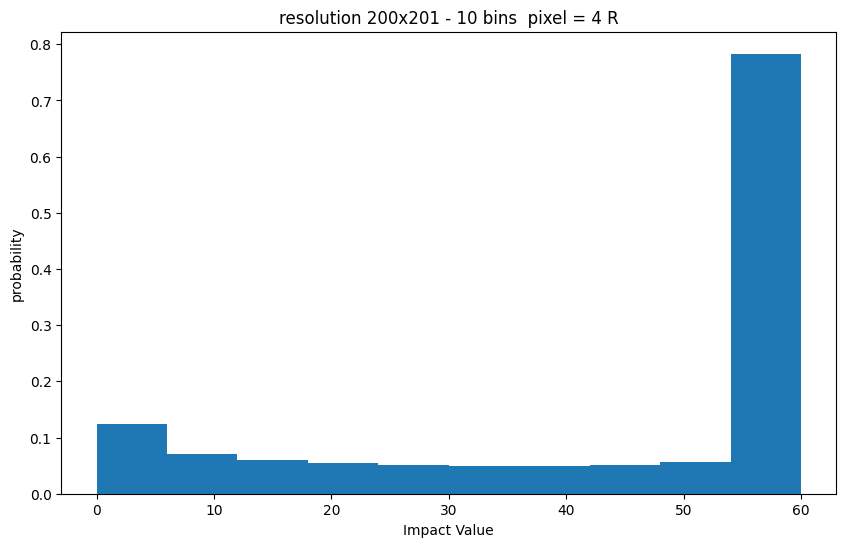

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [13]:

myPixel = pixel(horResolution=200,nBins =10)

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=200, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 2 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=1200, type = "center")
myPixel.makePlot(hist_counts, bin_edges," pixel = 4 R")
